### IMPORTS

In [1]:
from Inference.VariationalGNN import GNN
from Inference.Variational import MeanFieldVariationalDistribution

In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
def flip_parameters_to_tensors(module):
    attr = []
    while bool(module._parameters):
        attr.append( module._parameters.popitem() )
    setattr(module, 'registered_parameters_name', [])

    for i in attr:
        setattr(module, i[0], torch.zeros(i[1].shape,requires_grad=True))
        module.registered_parameters_name.append(i[0])

    module_name = [k for k,v in module._modules.items()]

    for name in module_name:
        flip_parameters_to_tensors(module._modules[name])

In [5]:
def set_all_parameters(module, theta):
    count = 0  

    for name in module.registered_parameters_name:
        a = count
        b = a + getattr(module, name).numel()
        t = torch.reshape(theta[0,a:b], getattr(module, name).shape)
        setattr(module, name, t)

        count += getattr(module, name).numel()

    module_name = [k for k,v in module._modules.items()]
    for name in module_name:
        count += set_all_parameters(module._modules[name], theta)
    return count

# Load data #

In [6]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

# Model principal

In [7]:
model = nn.Sequential( nn.Linear(1,50),
                       nn.Tanh(),               
                       nn.Linear(50,1),
                     ).to(device)
for params in model.parameters():
    params.requires_grad = False

In [8]:
param_count = get_param(model).shape[0]
param_count

151

In [9]:
flip_parameters_to_tensors(model)

# Calcul du posterior sur les paramètres principaux #

À chaque paramètre $\theta\in \mathbb{R}^{61}$ correspond un prédicteur $f_\theta:\mathbb{R}\to \mathbb{R}$. Le postérieur sur les paramètres principaux est défini comme:
$$
P(\theta | \text{data})=P(\theta)P(\text{data}|\theta)
$$
où $P(\theta)$ est un prior $N(0,I)$ et le likelihood est donné par
$$
P(\text{data}|\theta)=\prod_{(x,y)\in\text{data}}P(y|f_\theta(x),0.1)
$$
où $P(y|f_\theta(x),\sigma)$ la fonction de densité de la loi normale de moyenne $f_\theta(x)$ et d'écart-type $0.1$ (qui correspond au bruit utilisé pour générer les données).

In [10]:
#Prior
prior = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(param_count),torch.eye(param_count))

def logprior(theta):
    return prior.log_prob(theta)

In [11]:
def log_norm(y,y_,std):
    point_estimate= torch.distributions.normal.Normal(y_, std)
    return point_estimate.log_prob(y)

In [12]:
# likelihood of the parameters

def loglikelihood(theta):
    set_all_parameters(model, theta)
    y_pred = model(x_data)
    L = log_norm(y_pred, y_data, torch.tensor([0.1]))
    return torch.sum(L).unsqueeze(-1)


In [13]:
#Temperature
T=1
#log posterior
def logposterior(theta):
    return 1/T*logprior(theta).add(loglikelihood(theta))


# Modèle génératif: Hypernet autoencodeur

In [14]:
#choisir la dimension pour les paramètres latents
# lat_dim=5 donne des résultats intéressants!
lat_dim=5
nb_components=1

In [20]:
G=GNN(5,151,151,sigma=1.,layers=1,activation=nn.ReLU)

print('%%% Submodules %%%')
for i in G.named_modules():
    print(i)
print('%%% Parameters %%%')
for i in G.named_parameters():
    print(i)


%%% Submodules %%%
('', GNN(
  (transformer): Sequential(
    (0): Linear(in_features=5, out_features=151, bias=True)
    (1): ReLU()
    (2): Linear(in_features=151, out_features=151, bias=True)
  )
))
('transformer', Sequential(
  (0): Linear(in_features=5, out_features=151, bias=True)
  (1): ReLU()
  (2): Linear(in_features=151, out_features=151, bias=True)
))
('transformer.0', Linear(in_features=5, out_features=151, bias=True))
('transformer.1', ReLU())
('transformer.2', Linear(in_features=151, out_features=151, bias=True))
%%% Parameters %%%
('mu', Parameter containing:
tensor([0., 0., 0., 0., 0.]))
('rho', Parameter containing:
tensor(0.5413))
('transformer.0.weight', Parameter containing:
tensor([[-0.2699, -0.0680, -0.0779,  0.0431,  0.4310],
        [-0.2964,  0.3810, -0.2084, -0.4057,  0.2833],
        [ 0.4286, -0.1393, -0.3206, -0.1802, -0.1589],
        [ 0.2025, -0.3667, -0.2082,  0.1445, -0.1560],
        [ 0.2940,  0.1528,  0.1958, -0.1379,  0.3808],
        [-0.1818,  0

In [32]:
 
def init_weightsOut(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0., std=0.15)
        torch.nn.init.normal_(m.bias,mean=0., std=0.0)

G.transformer[2].apply(init_weightsOut)

#G.transformer[2].weight.data

Linear(in_features=151, out_features=151, bias=True)

# Visualisation de l'initialisation #

In [30]:
# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters

import matplotlib.pyplot as plt
%matplotlib notebook

theta =torch.stack([GNN.components[c](100).squeeze() for c in range(GNN.nb_comp)],dim=0).detach().numpy()


fig, axs = plt.subplots(6, 3,figsize=(8,15))
for k in range(6):
    for l in range(3):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
        for c in range(GNN.nb_comp):
            axs[k, l].scatter(theta[c,:,i[0]],theta[c,:,i[1]],marker='.',alpha=0.2)
        
fig.tight_layout()

AttributeError: type object 'GNN' has no attribute 'nb_comp'

<IPython.core.display.Javascript object>


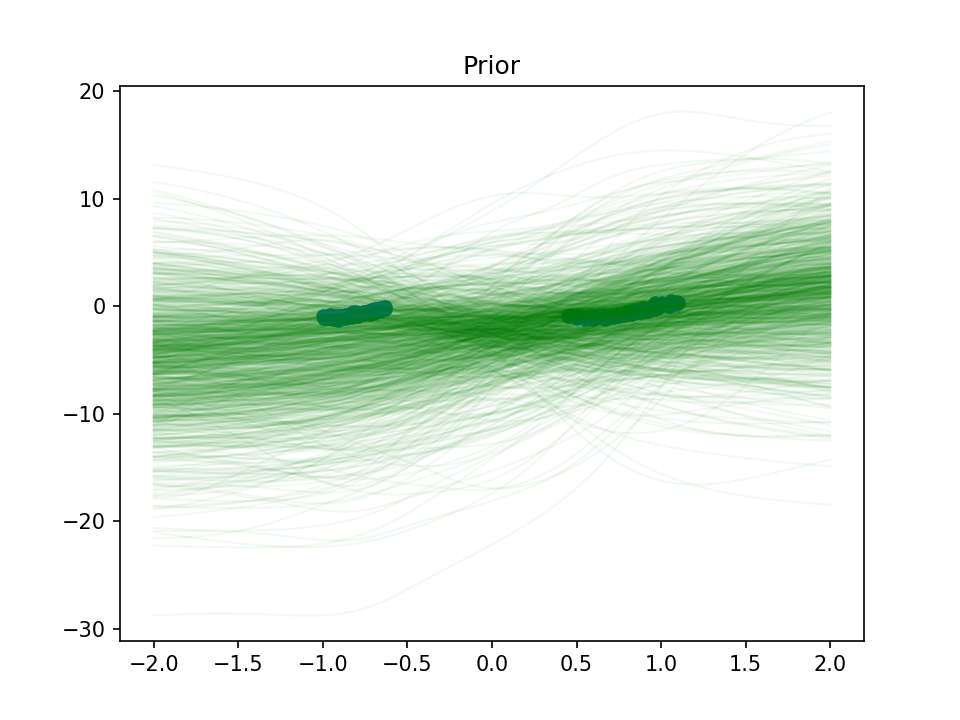

In [33]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
import math

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.title('Prior')

#comp=torch.distributions.categorical.Categorical(GNN.proportions)
plt.scatter(x_data.cpu(), y_data.cpu())
for i in range(1000):
#    c=comp.sample()
#    theta = GNN.components[c]().detach()
    theta=G()
    set_all_parameters(model, theta)
    y_test = model(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='green')
#    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='C'+str(c.numpy()))


In [34]:
GNN_optimizer = torch.optim.Adam(G.parameters(), lr=.1)
GNN_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(GNN_optimizer, patience=100, factor=0.5)
%matplotlib inline
liveloss = PlotLosses()

In [35]:
n_samples_KDE=1000
n_samples_VAR=200

In [ ]:
%matplotlib inline
for t in range(10000):
    logs = {}
    GNN_optimizer.zero_grad()

    learning_rate = GNN_optimizer.param_groups[0]['lr']
    
    theta=G(n_samples_VAR)
    ED=G.KDE(theta,n_samples_KDE).mean()
    
    LP=torch.Tensor(n_samples_VAR)
    for i in range(n_samples_VAR):
        LP[i]=logposterior(theta[i].unsqueeze(0))
    L =ED-LP.mean()

    L.backward()
    

    

    GNN_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    logs['entropie diff'] = -ED.detach().clone().cpu().numpy()
    liveloss.update(logs)

   
    
    if t % 5 == 0:
        liveloss.draw()

    GNN_optimizer.step()

    if learning_rate < 0.00001:
        break

In [32]:
for params in VAE.parameters():
    params.requires_grad = False

In [21]:
log_prop = torch.zeros(3).requires_grad_(True)

In [22]:

VAE_optimizer = torch.optim.Adam(list(VAE.parameters())+list(VAE2.parameters())+list(VAE3.parameters())+[log_prop], lr=.1)
VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=60, factor=0.5)
%matplotlib inline
liveloss = PlotLosses()

In [42]:

H=.5 #Kernel Density Estimation hyper-parameter 
n_samples_VAR = 100
n_samples_ED=10

In [57]:
%matplotlib inline
for t in range(10000):
    logs = {}
    VAE_optimizer.zero_grad()

    learning_rate = VAE_optimizer.param_groups[0]['lr']
    

    prop = log_prop.exp().mul(1/log_prop.exp().sum())
    
    LP=torch.Tensor(n_samples_VAR)
    LP2=torch.Tensor(n_samples_VAR)
    LP3=torch.Tensor(n_samples_VAR)

    for i in range(n_samples_VAR):
        LP[i]=logposterior(VAE())
        LP2[i]=logposterior(VAE2())
        LP3[i]=logposterior(VAE3())
        
    LQ=torch.Tensor(n_samples_ED,n_samples_ED)
    LQ2=torch.Tensor(n_samples_ED,n_samples_ED)
    LQ3=torch.Tensor(n_samples_ED,n_samples_ED)
    theta=VAE(n_samples_ED)
    theta2=VAE2(n_samples_ED)
    theta3=VAE3(n_samples_ED)
    for i in range(n_samples_ED):
        for j in range(i+1):
            LQ[i,j]=LQ[j,i]=log_norm_mv(theta[i],theta[j],H) 
            LQ2[i,j]=LQ2[j,i]=log_norm_mv(theta2[i],theta2[j],H)
            LQ3[i,j]=LQ3[j,i]=log_norm_mv(theta3[i],theta3[j],H)
    LQ_=LQ.logsumexp(0)-torch.log(torch.Tensor([n_samples_ED]))
    LQ2_=LQ2.logsumexp(0)-torch.log(torch.Tensor([n_samples_ED]))
    LQ3_=LQ3.logsumexp(0)-torch.log(torch.Tensor([n_samples_ED]))
        
    ED=prop[0]*LQ_.mean()+prop[1]*LQ2_.mean()+prop[2]*LQ3_.mean()
    LPm=prop[0]*LP.mean()+prop[1]*LP2.mean()+prop[2]*LP3.mean()
    
    L = ED-LPm

    L.backward()
    

    

    VAE_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    logs['entropie diff'] = -ED.mean().detach().clone().cpu().numpy()
    logs['prop'] = prop[2].detach().clone().cpu().numpy()    
    liveloss.update(logs)

    
    if t % 5 == 0:
        liveloss.draw()

    VAE_optimizer.step()

    if learning_rate < 0.0001:
        break

KeyboardInterrupt: 

In [53]:
prop

tensor([0.1012, 0.5648, 0.3339], grad_fn=<MulBackward0>)

<IPython.core.display.Javascript object>


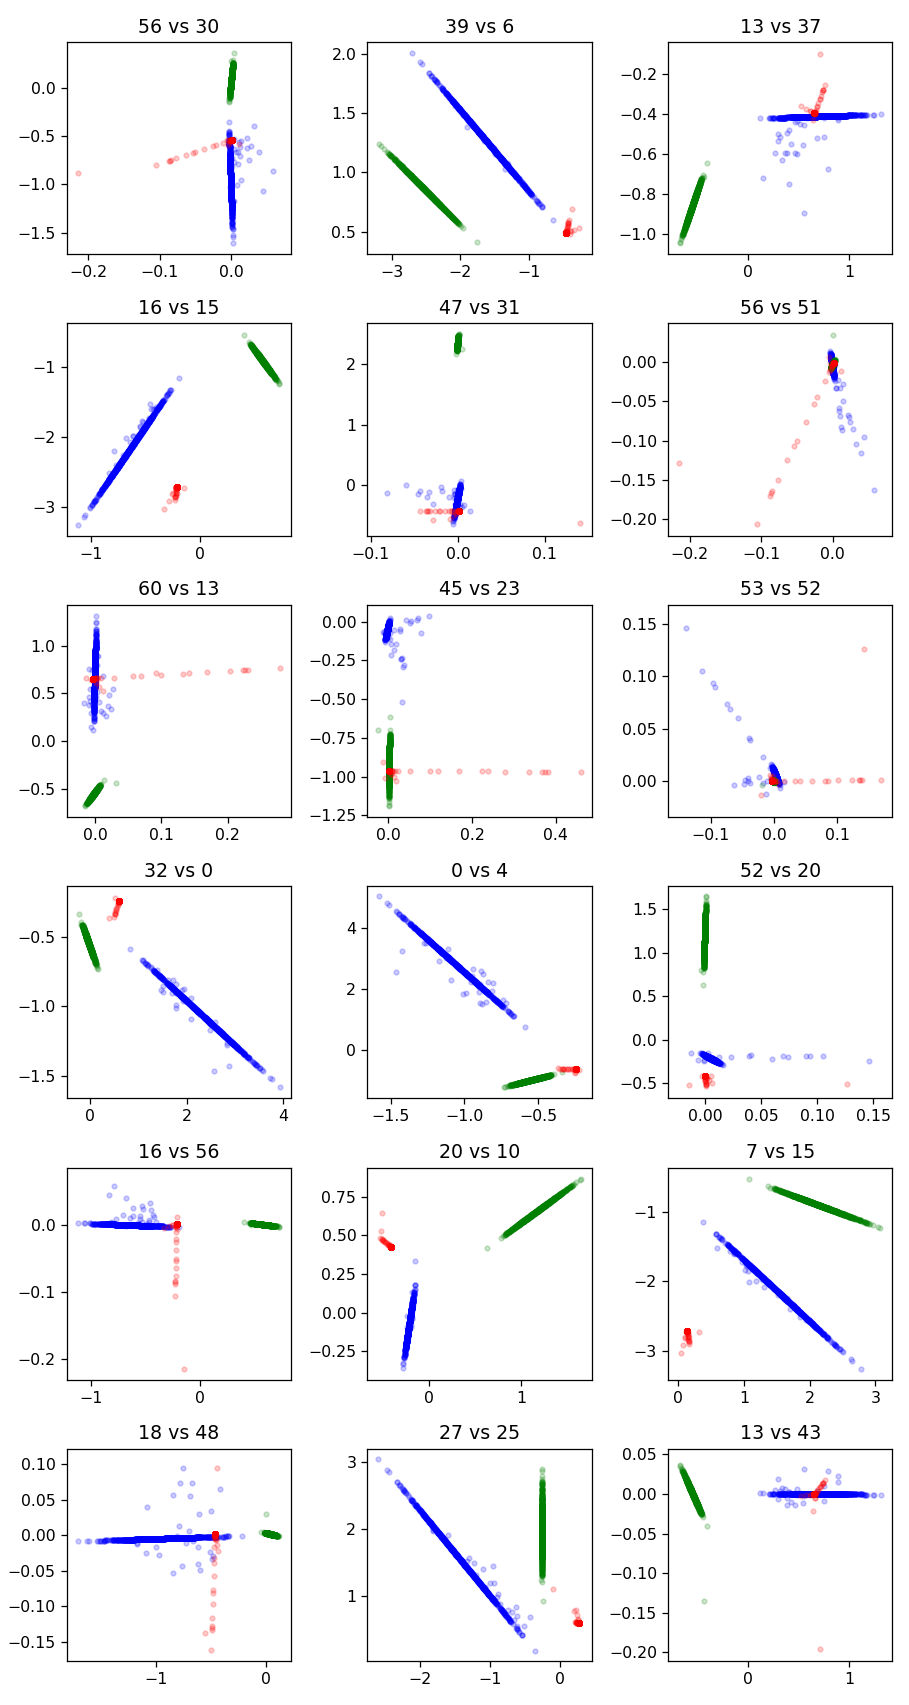

In [54]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters



L = VAE(1000).detach().numpy()
L2=VAE2(1000).detach().numpy()
L3=VAE3(1000).detach().numpy()


fig, axs = plt.subplots(6, 3,figsize=(8,15))
for k in range(6):
    for l in range(3):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(L[:,i[0]],L[:,i[1]],marker='.',alpha=0.2,color='blue')
        axs[k, l].scatter(L2[:,i[0]],L2[:,i[1]],marker='.',alpha=0.2,color='green')
        axs[k, l].scatter(L3[:,i[0]],L3[:,i[1]],marker='.',alpha=0.2,color='red')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

<IPython.core.display.Javascript object>


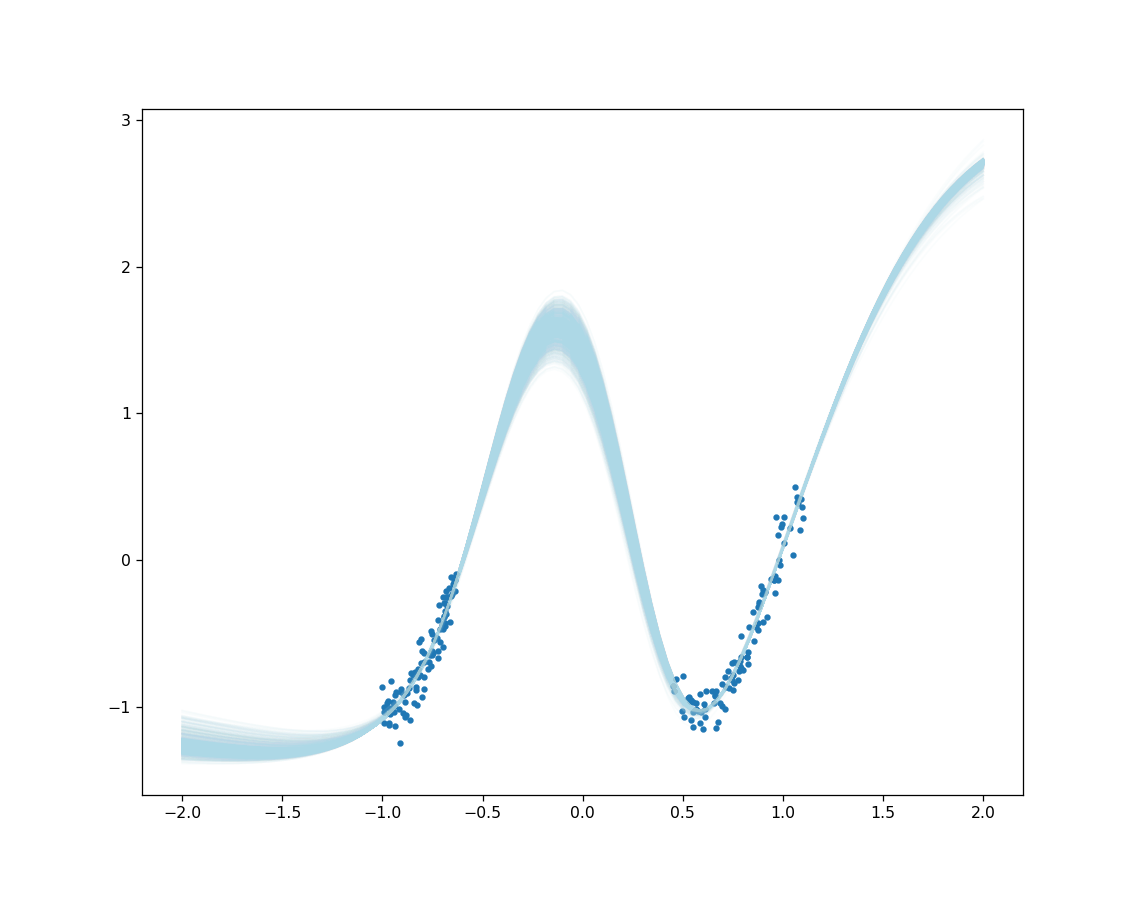

In [31]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

prop = log_prop.exp().mul(1/log_prop.exp().sum())
d = torch.distributions.categorical.Categorical(prop)
x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
plt.scatter(x_data.cpu(), y_data.cpu(),marker='.')
for i in range(1000):
    j=d.sample()
    theta=[VAE(),VAE2(),VAE3()]
    set_all_parameters(model, theta[0])
    y_test = model(x_test)    
#    plt.axis('scaled')
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')



In [33]:
unbounded_prop_new = torch.tensor(0.0).requires_grad_(True)



In [35]:

VAE_optimizer = torch.optim.Adam(list(VAE2.parameters())+[unbounded_prop_new], lr=.1)
VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=60, factor=0.5)
%matplotlib inline
liveloss = PlotLosses()

In [36]:

H=.5 #Kernel Density Estimation hyper-parameter 
n_samples_VAR = 100
n_samples_ED=10

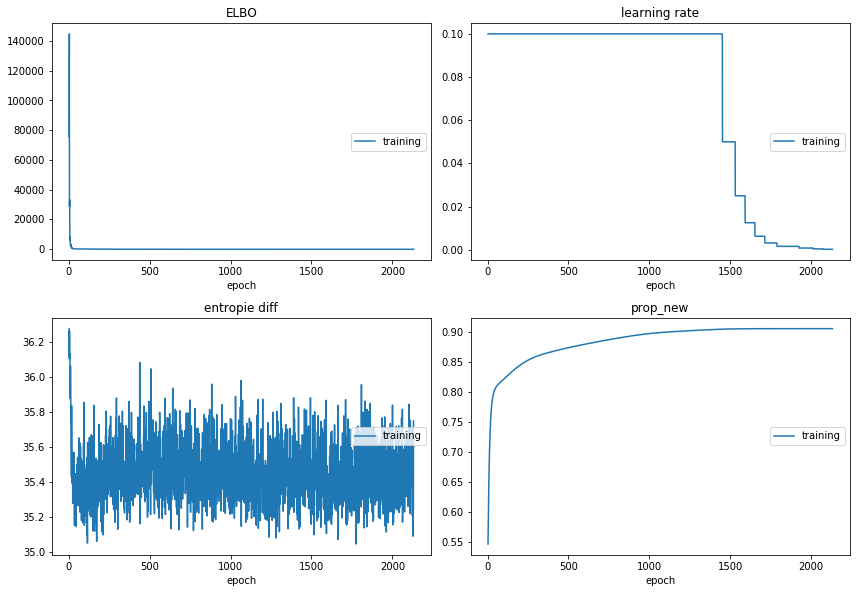

ELBO:
training   (min: -130.578, max: 144801.078, cur: -129.834)

learning rate:
training   (min:    0.000, max:    0.100, cur:    0.000)

entropie diff:
training   (min:   35.047, max:   36.344, cur:   35.749)

prop_new:
training   (min:    0.500, max:    0.906, cur:    0.906)


In [37]:
%matplotlib inline
for t in range(10000):
    logs = {}
    VAE_optimizer.zero_grad()

    learning_rate = VAE_optimizer.param_groups[0]['lr']
    

    prop_new = torch.sigmoid(unbounded_prop_new)
    
    LP=torch.Tensor(n_samples_VAR)
    LP2=torch.Tensor(n_samples_VAR)

    for i in range(n_samples_VAR):
        LP[i]=logposterior(VAE())
        LP2[i]=logposterior(VAE2())

    LQ=torch.Tensor(n_samples_ED,n_samples_ED)
    LQ2=torch.Tensor(n_samples_ED,n_samples_ED)
    theta=VAE(n_samples_ED)
    theta2=VAE2(n_samples_ED)
    for i in range(n_samples_ED):
        for j in range(i+1):
            LQ[i,j]=LQ[j,i]=log_norm_mv(theta[i],theta[j],H) 
            LQ2[i,j]=LQ2[j,i]=log_norm_mv(theta2[i],theta2[j],H) 
    LQ_=LQ.logsumexp(0)-torch.log(torch.Tensor([n_samples_ED]))
    LQ2_=LQ2.logsumexp(0)-torch.log(torch.Tensor([n_samples_ED]))
        
    ED=prop_new*LQ_.mean()+(1-prop_new)*LQ2_.mean()
    LPm=prop_new*LP.mean()+(1-prop_new)*LP2.mean()
    
    L = ED-LPm

    L.backward()
    

    

    VAE_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    logs['entropie diff'] = -ED.mean().detach().clone().cpu().numpy()
    logs['prop_new'] = prop_new.detach().clone().cpu().numpy()    
    liveloss.update(logs)

    
    if t % 5 == 0:
        liveloss.draw()

    VAE_optimizer.step()

    if learning_rate < 0.0001:
        break

# Résultats #

In [25]:
(-ED.mean(),LP.mean())

(tensor(36.5773, grad_fn=<NegBackward>), tensor(nan, grad_fn=<MeanBackward0>))

<IPython.core.display.Javascript object>


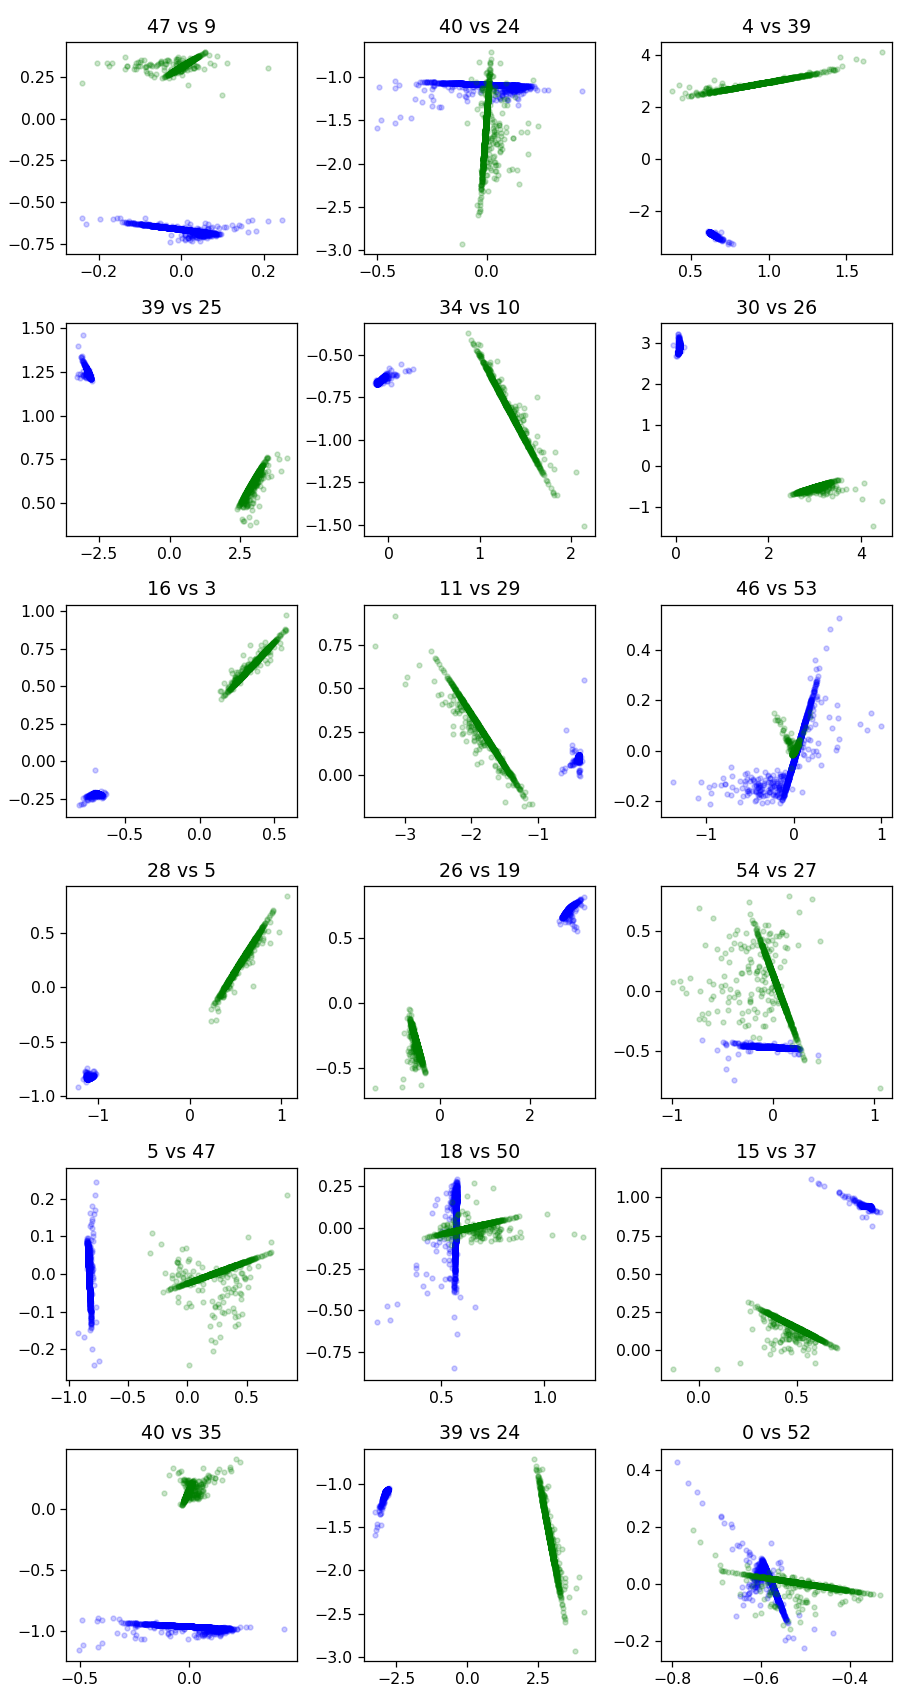

In [39]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters



L = VAE(1000).detach().numpy()
L2=VAE2(1000).detach().numpy()


fig, axs = plt.subplots(6, 3,figsize=(8,15))
for k in range(6):
    for l in range(3):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(L[:,i[0]],L[:,i[1]],marker='.',alpha=0.2,color='blue')
        axs[k, l].scatter(L2[:,i[0]],L2[:,i[1]],marker='.',alpha=0.2,color='green')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

## Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution ##


<IPython.core.display.Javascript object>


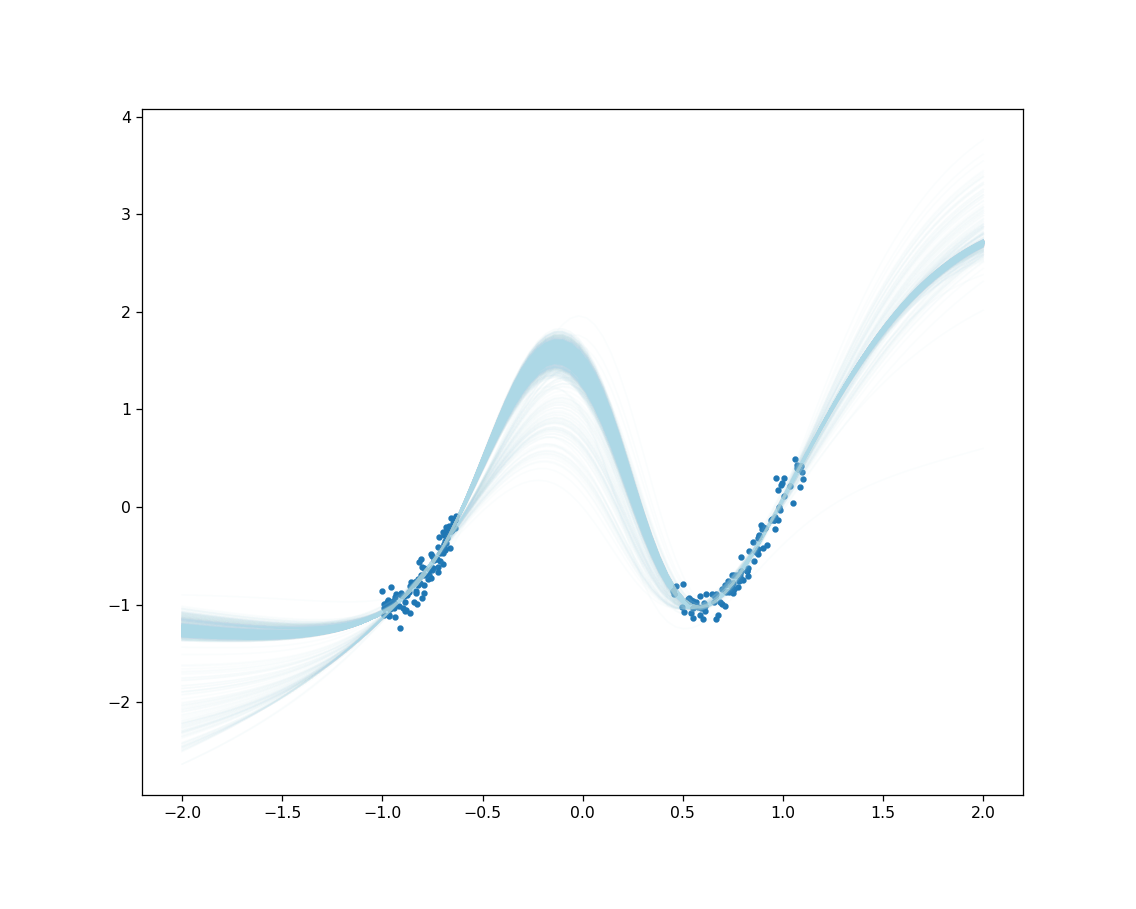

In [40]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

prop_new=torch.sigmoid(unbounded_prop_new)
d = torch.distributions.categorical.Categorical(torch.Tensor([prop_new,1-prop_new]))
x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
plt.scatter(x_data.cpu(), y_data.cpu(),marker='.')
for i in range(1000):
    j=d.sample()
    theta=[VAE(),VAE2()]
    set_all_parameters(model, theta[j])
    y_test = model(x_test)    
#    plt.axis('scaled')
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')



In [105]:
# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt


L = VAE(10000).detach()
P=torch.Tensor(10000,1)

for i in range(10000):
    P[i]=logposterior(L[i].unsqueeze(0))

print((P.mean(),P.std()))


(tensor(37.2269), tensor(92.1520))


<IPython.core.display.Javascript object>


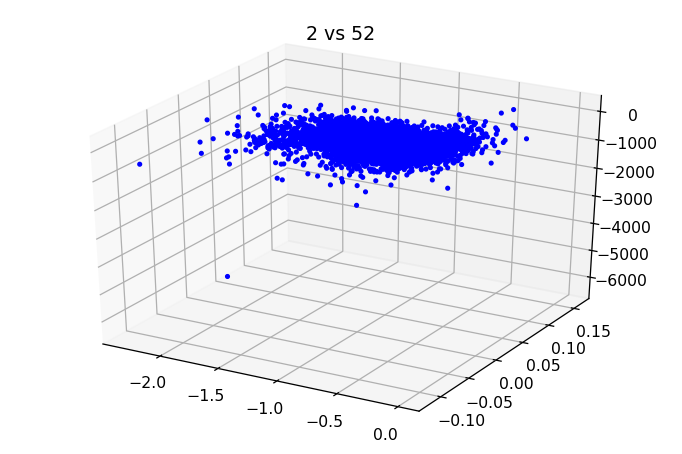

In [113]:
%matplotlib notebook

fig = plt.figure()

for k in range(1):
    for l in range(1):
        k_=k+1
        l_=l+1
        ax = fig.add_subplot(k_,1,l_, projection='3d')
        i=(2,52)#np.random.choice(a=np.arange(param_count), size=2,replace=False)
        ax.scatter(L[:,i[0]],L[:,i[1]],P, marker='.',alpha=1.,color='blue')
        ax.set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()